In [1]:
import argparse
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import kerastuner as kt
from kerastuner.tuners import Hyperband
import statsmodels.api as sm

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA, ALPHABET_PROTEIN
from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    one_hot_encode_classes,
    split_train_test_set,
    combine_sequences,
)
from rna_learn.hyperband import hyperband_densenet_model

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

## Hyperband optimisation results

In [3]:
hyperband_run_id = 'run_tdscx_top10'

build_model_fn = hyperband_densenet_model(n_inputs=len(ALPHABET_DNA))

hypermodel = Hyperband(
    build_model_fn,
    max_epochs=100,
    objective=kt.Objective('val_loss', 'min'),
    factor=3,
    hyperband_iterations=1,
    project_name=f'hyperband_logs/dna/{hyperband_run_id}',
)

INFO:tensorflow:Reloading Oracle from existing project ./hyperband_logs/dna/run_tdscx_top10/oracle.json
INFO:tensorflow:Reloading Tuner from ./hyperband_logs/dna/run_tdscx_top10/tuner0.json


In [4]:
best_hyperparameters_sets = hypermodel.get_best_hyperparameters(10)

In [5]:
best_model_idx = 0
best_hyperparameters = best_hyperparameters_sets[best_model_idx]

In [6]:
best_hyperparameters.values

{'n_layers': 14,
 'growth_rate': 12,
 'l2_reg': 1e-05,
 'learning_rate': 0.0005,
 'kernel_size_l1': 2,
 'kernel_size_l2': 4,
 'kernel_size_l3': 4,
 'kernel_size_l4': 8,
 'kernel_size_l5': 3,
 'kernel_size_l6': 2,
 'kernel_size_l7': 7,
 'kernel_size_l8': 9,
 'kernel_size_l9': 10,
 'kernel_size_l10': 3,
 'kernel_size_l11': 7,
 'kernel_size_l12': 8,
 'kernel_size_l13': 6,
 'kernel_size_l14': 8,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': 'd0f76055db1862f43951424cfb7c923f'}

In [7]:
print(f'Learning rate:')
for i in range(10):
    l = best_hyperparameters_sets[i].values['learning_rate']
    print(f'{i+1:2d}: {l:.0e}')

Learning rate:
 1: 5e-04
 2: 1e-03
 3: 1e-03
 4: 1e-03
 5: 1e-03
 6: 5e-04
 7: 1e-03
 8: 1e-03
 9: 1e-03
10: 1e-03


In [8]:
print(f'L2 regularization:')
for i in range(10):
    l = best_hyperparameters_sets[i].values['l2_reg']
    print(f'{i+1:2d}: {l:.0e}')

L2 regularization:
 1: 1e-05
 2: 1e-05
 3: 5e-06
 4: 1e-05
 5: 1e-05
 6: 1e-05
 7: 5e-06
 8: 5e-06
 9: 1e-05
10: 5e-05


In [9]:
print(f'Number of layers:')
for i in range(10):
    l = best_hyperparameters_sets[i].values['n_layers']
    print(f'{i+1:2d}: {l:2d}')

Number of layers:
 1: 14
 2: 14
 3: 12
 4: 10
 5: 12
 6: 14
 7:  8
 8: 12
 9: 14
10: 10


In [10]:
print(f'Growth rate:')
for i in range(10):
    l = best_hyperparameters_sets[i].values['growth_rate']
    print(f'{i+1:2d}: {l:2d}')

Growth rate:
 1: 12
 2: 10
 3: 12
 4: 12
 5:  8
 6: 12
 7: 12
 8: 12
 9: 10
10: 10


In [11]:
print(f'Kernel size (layer 1)')
for i in range(10):
    l = best_hyperparameters_sets[i].values['kernel_size_l1']
    print(f'{i+1:2d}: {l:2d}')

Kernel size (layer 1)
 1:  2
 2:  7
 3:  9
 4:  2
 5:  7
 6:  2
 7:  5
 8:  9
 9:  7
10:  5


In [12]:
trials = hypermodel.oracle.get_best_trials(10)
best_model = hypermodel.load_model(trials[best_model_idx])

In [13]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 12)     108         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 16)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 12)     780         concat_1[0][0]               

__________________________________________________________________________________________________
mean_and_std (Dense)            (None, 2)            346         dropout[0][0]                    
__________________________________________________________________________________________________
independent_normal (Independent ((None, 1), (None, 1 0           mean_and_std[0][0]               
Total params: 91,378
Trainable params: 91,378
Non-trainable params: 0
__________________________________________________________________________________________________


## Best model evaluation

In [14]:
train_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_full_train.csv')
test_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_full_test.csv')

train_df = pd.read_csv(train_set_path)
dataset_df = pd.read_csv(test_set_path)

In [15]:
alphabet = ALPHABET_DNA
y_train = train_df['temperature'].values.astype('float64')
mean, std = np.mean(y_train), np.std(y_train)

raw_sequences = dataset_df['nucleotide_sequence'].values

x_dna = sequence_embedding(raw_sequences, alphabet, dtype='float32')

y = dataset_df['temperature'].values.astype('float32')
y_norm = normalize(y, mean, std)

In [16]:
%%time
b = int(np.ceil(len(x_dna) / 30))
y_mean = []
for idx in range(30):
    x_ = x_dna[idx * b:(idx + 1) * b]
    y_hat_ = best_model(x_)
    y_mean_ = denormalize(y_hat_.mean().numpy(), mean, std).flatten().tolist()
    y_mean += y_mean_

y_mean = np.array(y_mean)

CPU times: user 13min 20s, sys: 5min 10s, total: 18min 31s
Wall time: 3min 45s


In [17]:
mae = np.mean(np.abs(y_mean.flatten() - y))
rmse = np.sqrt(np.mean((y_mean.flatten() - y) **2))
correlation = np.corrcoef(y, y_mean.flatten())[0, 1]

print(f'Mean Absolute Error    = {mae:.2f}')
print(f'Root Mean Square Error = {rmse:.2f}')
print(f'Correlation            = {correlation:.2f}')

Mean Absolute Error    = 10.12
Root Mean Square Error = 12.92
Correlation            = 0.72


In [18]:
def predictions_per_specie(dataset_df, y_true, y_pred):
    y_species_pred = []
    y_species_actual = []
    y_species_pred_std  = []
    
    sequence_ids = sorted(dataset_df['gtdb_genome_representative'].unique().tolist())
    for sequence_id in sequence_ids:
        indices = dataset_df[dataset_df['gtdb_genome_representative'] == sequence_id].index
        
        truth = y_true[indices[0]]
        prediction = np.mean(y_pred[indices])
        prediction_std = np.std(y_pred[indices])
        
        y_species_actual.append(truth)
        y_species_pred.append(prediction)
        y_species_pred_std.append(prediction_std)
    
    return np.array(y_species_actual), np.array(y_species_pred), np.array(y_species_pred_std)

In [19]:
def plot_true_vs_prediction_per_specie(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(0, 80)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        ax.plot(y_t, y_p, 'o', color=palette[0])
    
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return f, ax

In [20]:
y_species_actual, y_species_pred, y_species_pred_std = predictions_per_specie(dataset_df, y, y_mean)

In [21]:
mae_species = np.mean(np.abs(y_species_pred.flatten() - y_species_actual))
rmse_species = np.sqrt(np.mean((y_species_pred.flatten() - y_species_actual) **2))
corr_species = np.corrcoef(y_species_actual, y_species_pred.flatten())[0, 1]

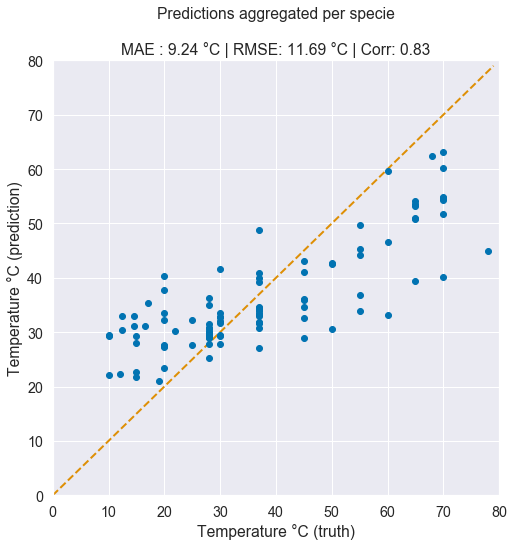

In [22]:
f, ax = plot_true_vs_prediction_per_specie(y_species_actual, y_species_pred);
title = f'Predictions aggregated per specie\n\n'
title += f'MAE : {mae_species:.2f} °C | '
title += f'RMSE: {rmse_species:.2f} °C | '
title += f'Corr: {corr_species:.2f}'
ax.set_title(title);

### Results per gene

In [23]:
def mae_per_gene(dataset_df, y_true, y_pred, plot_top=20):
    f, ax = plt.subplots(1, 1, figsize=(6, 12))
    palette = sns.color_palette()
    
    genes = np.array(sorted(dataset_df['gene_name'].unique().tolist()))
    
    results = []
    for i, gene in enumerate(genes):
        df = dataset_df[dataset_df['gene_name'] == gene]
        indices = df.index

        y_p = y_pred[indices]
        y_t = y_true[indices]
        
        results.append(np.mean(np.abs(y_p - y_t)))
    
    sorted_idx = np.argsort([np.sum(r) for r in results]).tolist()
    sorted_maes = np.array(results)[sorted_idx]
    
    cm = pd.DataFrame(
        sorted_maes[:plot_top], 
        index=[f'{g}' for i, g in enumerate(genes[sorted_idx][:plot_top])],
        columns=[''],
    )
    sns.heatmap(cm, cmap="Greys_r", annot=True, fmt='.2f', cbar=False, ax=ax);
    plt.yticks(rotation=0)
    ax.set_title('Mean average error (°C)')
    
    return f, ax, genes[sorted_idx], sorted_maes

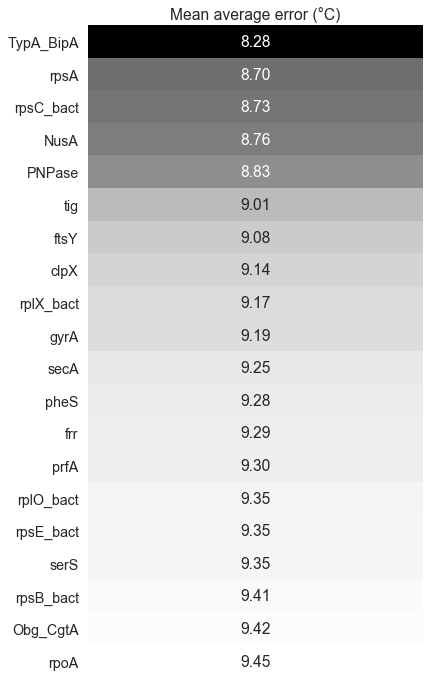

In [24]:
_, _, sorted_genes, sorted_gene_maes = mae_per_gene(dataset_df, y, y_mean.flatten(), plot_top=20)